In [89]:
# imports
import pandas as pd
import math
import numpy as np

# read in training data
train = pd.read_csv('train.csv')

# read in test d

train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [90]:
# extract y=SalePrice from training data
prices = train['SalePrice']
train = train.drop('SalePrice', axis=1)

In [91]:
# try first linear regression with small number of columns
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(train[['LotArea', 'YrSold', 'MSSubClass']], prices)
reg.score(train[['LotArea', 'YrSold', 'MSSubClass']], prices)

0.072596972569531015

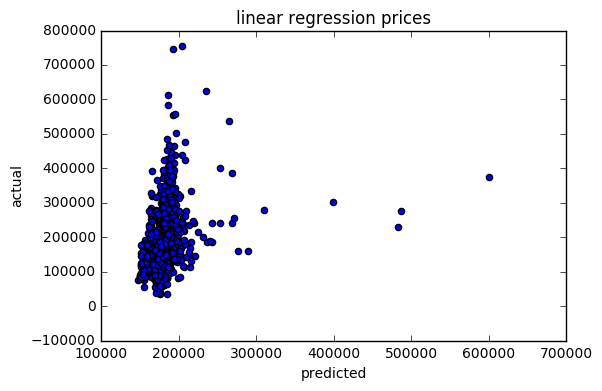

In [92]:
# plot scatter plot of actual vs predicted prices
import matplotlib.pyplot as plt
predictions = reg.predict(train[['LotArea', 'YrSold', 'MSSubClass']])
plt.scatter(predictions, prices)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("linear regression prices")
plt.show()

In [93]:
# first try at random forest model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(train[['LotArea', 'YrSold','MSSubClass']], prices)
model.score(train[['LotArea', 'YrSold', 'MSSubClass']], prices)

0.84563457749996362

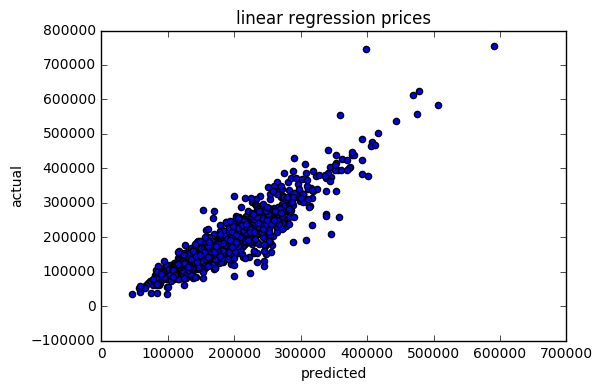

In [94]:
#plot
import matplotlib.pyplot as plt
predictions = model.predict(train[['LotArea', 'YrSold', 'MSSubClass']])
plt.scatter(predictions, prices)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("linear regression prices")
plt.show()

In [95]:
# read in test data and use random tree model to
# predict prices
test = pd.read_csv('test.csv')

predictions = model.predict(test[['LotArea', 'YrSold', 'MSSubClass']])

# create submission dataframe and write a submission file
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predictions
    })
results = submission.to_csv("results1.csv",index=False)

In [96]:
# now let's try data cleaning
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [97]:
# lot frontage may be important
# for those without data, assume frontage is sqrt of area
def process_LotFrontage(train):
    train.LotFrontage = train.apply(
        lambda r : math.sqrt(r['LotArea'])\
        if pd.isnull(r['LotFrontage'])\
        else r.LotFrontage, axis=1
    )
    return train

In [98]:
train = process_LotFrontage(train)

model.fit(train[['LotArea', 'YrSold', 'MSSubClass', 'LotFrontage']], prices)
model.score(train[['LotArea', 'YrSold', 'MSSubClass', 'LotFrontage']], prices)

0.87638775735368668

In [99]:
# only a few houses have alleys
# create a new feature HasAlley 1 if has, 0 if doesn't

def processAlley(train):
    train['HasAlley'] = train.apply(
        lambda r : 0 if pd.isnull(r.Alley) else 1, axis=1
    )
    return train

In [100]:
#processAlley(train)
#model.fit(train[['LotArea', 'YrSold', 'MSSubClass',\
#                 'LotFrontage', 'HasAlley']], prices)
#model.score(train[['LotArea', 'YrSold', 'MSSubClass',\
#                   'LotFrontage', 'HasAlley']], prices)

# appears to make predictions worse!

In [101]:
#train.SaleCondition.unique()
# factors I think might be important
# LotFrontage, LotArea, Neighborhood, YearBuilt, 
# FullBath, HalfBath, BsmFullBath, BsmtHalfBath, 
# KitchenAbvGr, BedroomAbvGr, GarageCars, YrSold, 
# MoSold, PoolArea

# factors to look at in 2nd pass
# MSZoning, BldgType, LowQualFinSF, KitchenQual

In [102]:
# factors which do not contain missing data:
# LotArea, YearBuilt, BsmtFullBath, BsmtHalfBath,
# FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr,
# GarageCars, YrSold, MoSold, PoolArea

# already processed for LotFrontage and used MSSubClass

predictors = ["MSSubClass","LotFrontage", "LotArea",\
               "YearBuilt", "BsmtFullBath", "BsmtHalfBath",\
               "FullBath", "HalfBath", "BedroomAbvGr",\
               "KitchenAbvGr", "GarageCars", "YrSold",\
               "MoSold", "PoolArea"]



In [103]:
# try training linear regression
reg.fit(train[predictors], prices)
reg.score(train[predictors], prices)

0.60593578575320794

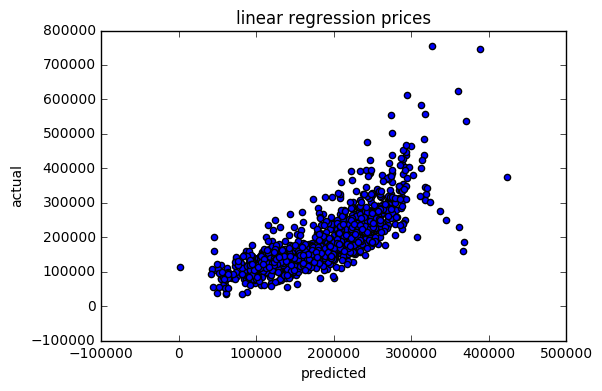

In [104]:
predictions = reg.predict(train[predictors])
plt.scatter(predictions, prices)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("linear regression prices")
plt.show()

In [105]:
# try training random forest
model.fit(train[predictors], prices)
model.score(train[predictors], prices)

0.95098321464530733

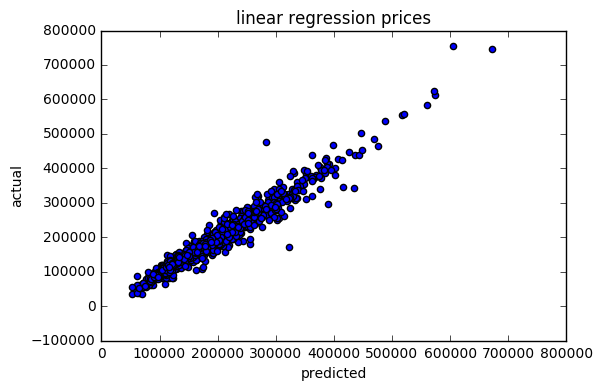

In [106]:
predictions = model.predict(train[predictors])
plt.scatter(predictions, prices)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("linear regression prices")
plt.show()

In [107]:
# try new model on test data
# first process test data
test = process_LotFrontage(test)
# test.info()
# need to handle nulls in GarageCars, BsmtFullBath and
# BsmtHalfBath

test.GarageCars = test.GarageCars.fillna(0)
test.BsmtFullBath = test.BsmtFullBath.fillna(0)
test.BsmtHalfBath = test.BsmtHalfBath.fillna(0)


In [108]:
predictions = model.predict(test[predictors])

# create submission dataframe and write a submission file
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predictions
    })
results = submission.to_csv("results2.csv",index=False)

In [109]:
# now look at neighborhoods
train.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [110]:
neighborhoods = train.Neighborhood.unique()
neighborhoods = neighborhoods.tolist()

def process_Neighborhood(train):
    for i in neighborhoods:
        train[i] = train.apply(
            lambda r : 1\
            if r.Neighborhood==i \
            else 0, axis=1
        )
    return train

In [111]:
train = process_Neighborhood(train)

predictors = ["MSSubClass","LotFrontage", "LotArea",\
               "YearBuilt", "BsmtFullBath", "BsmtHalfBath",\
               "FullBath", "HalfBath", "BedroomAbvGr",\
               "KitchenAbvGr", "GarageCars", "YrSold",\
               "MoSold", "PoolArea"]

predictors = predictors + neighborhoods

In [112]:
# model this
# try training random forest
model.fit(train[predictors], prices)
model.score(train[predictors], prices)

0.94922976613264454

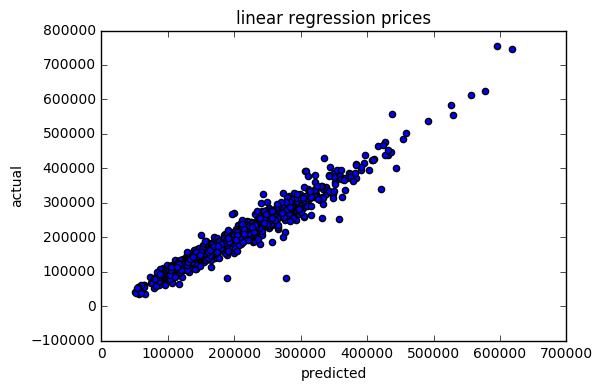

In [113]:
predictions = model.predict(train[predictors])
plt.scatter(predictions, prices)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("linear regression prices")
plt.show()

In [114]:
# try it on the test data

test = process_Neighborhood(test)

predictions = model.predict(test[predictors])

# create submission dataframe and write a submission file
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predictions
    })
results = submission.to_csv("results3.csv",index=False)

In [115]:
# try features scaling with predictors

def scale_all_features(train):
    train[predictors] = train[predictors].apply(lambda\
                                           x: x/x.max(), axis=0)
    return train

In [116]:
new_train = scale_all_features(train)
new_test = scale_all_features(test)

In [117]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

In [118]:
# 5-fold cross validation with the Accuracy metric
def compute_score(res, X, y, scoring='accuracy'):
    xval=cross_val_score(res, X, y, cv=5, scoring=scoring)
    return np.mean(xval)

In [119]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
mod = ExtraTreesRegressor(n_estimators=200)
mod = mod.fit(train[predictors], prices)

features = pd.DataFrame()
features['feature'] = train[predictors].columns
features['importance'] = mod.feature_importances_

In [125]:
features.sort_values(['importance'],ascending=False)

,feature,importance
10,GarageCars,0.264454
6,FullBath,0.163315
3,YearBuilt,0.115582
24,NridgHt,0.070915
17,NoRidge,0.054130
2,LotArea,0.038850
4,BsmtFullBath,0.030258
8,BedroomAbvGr,0.030056
1,LotFrontage,0.025975
7,HalfBath,0.024755


In [126]:
# random forest hyperparameters
forest = RandomForestRegressor()

parameter_grid = {
    'max_depth' : [None,4,5,6,7,8],
    'n_estimators' : [3,10,30,100,200,400]
}

cross_validation = KFold(len(prices),n_folds=5)

grid_search = GridSearchCV(
    forest,
    param_grid=parameter_grid,
    cv=cross_validation
)

grid_search.fit(train[predictors], prices)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


Best score: 0.725448222883
Best parameters: {'n_estimators': 100, 'max_depth': None}


In [127]:
grid_search.score(train[predictors], prices)

0.9679768728954351

In [128]:
output = grid_search.predict(test[predictors])
df_output = pd.DataFrame()
df_output['Id'] = test['Id']
df_output['SalePrice'] = output
df_output[['Id', 'SalePrice']].to_csv('results4.csv', index=False)